# Focusing Theory figure



In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
focusing = read.csv("../data/Enzyme_60sec.csv",header = FALSE)


In [3]:
focusing %<>% rename(Add_ATP = V1) %>% 
    mutate(Distance =seq(0,400,length.out = length(Add_ATP)) ) %>%
    filter(Distance <= 360, Distance >= 40) %>%
    mutate(Distance =seq(-160,160,length.out = length(Add_ATP)) )

In [4]:
focusing$channel[focusing$Distance <= -60] <- 'left'
focusing$channel[focusing$Distance > -60 & focusing$Distance <= 60] <- 'center'
focusing$channel[focusing$Distance > 60] <- 'right'
focusing$channel <- factor(focusing$channel, levels = c ('left','center','right'))

In [5]:
focusing %<>% mutate(Control = 0.2) %>% gather(Experiment,Concentration,Control,Add_ATP)

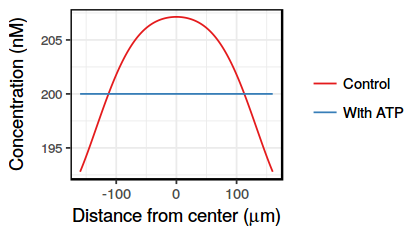

In [6]:

options(repr.plot.width = 3.5, repr.plot.height = 2)
model <- ggplot(data = focusing,aes(x = Distance,color = Experiment)) + 
    geom_line(aes(y = Concentration*1000)) +
    theme_bw() +
xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
ylab(expression(paste("Concentration (nM)", sep = ""))) +
theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) +
    scale_color_brewer(palette = 'Set1', labels = c('Control','With ATP')) +
    scale_y_continuous(breaks = c(195,200,205))

print(model)

#### Getting Experimental Data

In [7]:
bychannel <- focusing %>% group_by(Experiment,channel) %>%
    summarise(concentration = sum(Concentration))

bychannel %<>% group_by(Experiment) %>% mutate(normalized = concentration / sum(concentration))
bychannel

Experiment,channel,concentration,normalized
Add_ATP,left,9.993177,0.3085717
Add_ATP,center,12.398915,0.3828566
Add_ATP,right,9.993177,0.3085717
Control,left,10.000000,0.3125000
Control,center,12.000000,0.3750000
Control,right,10.000000,0.3125000


In [53]:
bychannel_recap <- read.csv("../data/bychannel_recap2.csv", header=TRUE, stringsAsFactors=FALSE)

In [54]:
bychannel_recap

X,channel,Substrate,Experiment,orig,smooth,lo,hi
1,left,dg,ctrl,46.68531,47.05010,45.06864,49.03530
2,left,dg,substrate,31.90805,32.69220,30.59474,35.32258
3,left,mannose,ctrl,64.12445,63.67301,60.45472,66.59443
4,left,mannose,substrate,44.50118,44.52957,42.01694,47.08725
5,left,lg,ctrl,63.04916,62.91964,58.06020,67.91187
6,left,lg,substrate,65.12966,64.28462,59.92722,68.80208
7,left,amppcp,ctrl,54.19623,53.90575,50.25103,57.77995
8,left,amppcp,substrate,54.79734,54.13189,50.79065,57.38445
9,center,dg,ctrl,100.63459,100.00000,98.49681,101.40718
10,center,dg,substrate,129.75743,128.62129,124.50580,132.67915


In [55]:
exp.df <- select(filter(bychannel_recap,Substrate == 'mannose'),channel,Experiment,orig,smooth,lo,hi)

In [56]:
exp.df %<>% rename(concentration = smooth)

In [57]:
exp.df

channel,Experiment,orig,concentration,lo,hi
left,ctrl,64.12445,63.67301,60.45472,66.59443
left,substrate,44.50118,44.52957,42.01694,47.08725
center,ctrl,91.26515,90.97689,88.24161,93.63860
center,substrate,111.87728,112.19112,108.43117,115.83945
right,ctrl,43.34943,43.92464,41.55840,46.57328
right,substrate,42.36057,42.03774,39.13127,44.81980


In [58]:
exp.df %<>% mutate(Experiment=replace(Experiment, Experiment=='ctrl', 'Control')) %>%
    mutate(Experiment=replace(Experiment, Experiment=='substrate', 'Add_ATP')) 


### Plotting histogram for theoretical data

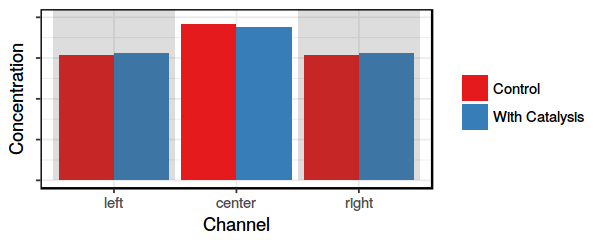

In [59]:
options(repr.plot.width = 5, repr.plot.height = 2)
integrated <- ggplot(data = bychannel , 
                     aes(x=channel, y=normalized, fill = Experiment)) + 
    geom_bar(stat = 'identity',position = 'dodge') +
    xlab("Channel") +
    ylab("Concentration") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 

    annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = +0.5, alpha = .2) +
    annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.55, alpha = .2) +
        coord_cartesian(ylim = c(0., .4)) +
    scale_fill_brewer(palette = "Set1",labels = c("Control","With Catalysis"))

print(integrated)

### Plotting Comparison Histogram
First we need to merge the data frames then plot a joined histogram.

In [60]:
tot.df <- full_join(exp.df,bychannel)

Joining, by = c("channel", "Experiment", "concentration")
Warning message in full_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

In [61]:
tot.df$Experiment.Type = c("exp","exp","exp","exp","exp","exp","theo","theo","theo","theo","theo","theo")

In [66]:
center.tot.df <- filter(tot.df,channel == 'center') %>% 
    group_by(Experiment.Type) %>% mutate(normalized = concentration / min(concentration)) %>%
    mutate(lo = lo/min(concentration)) %>%
    mutate(hi = hi/min(concentration))
glimpse(center.tot.df)

Observations: 4
Variables: 8
$ channel         <chr> "center", "center", "center", "center"
$ Experiment      <chr> "Control", "Add_ATP", "Add_ATP", "Control"
$ orig            <dbl> 91.26515, 111.87728, NA, NA
$ concentration   <dbl> 90.97689, 112.19112, 12.39892, 12.00000
$ lo              <dbl> 0.9699343, 1.1918540, NA, NA
$ hi              <dbl> 1.029257, 1.273284, NA, NA
$ normalized      <dbl> 1.000000, 1.233183, 1.033243, 1.000000
$ Experiment.Type <chr> "exp", "exp", "theo", "theo"


In [67]:
center.tot.df$Experiment <- factor(center.tot.df$Experiment, levels = c ('Control','Add_ATP'))

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

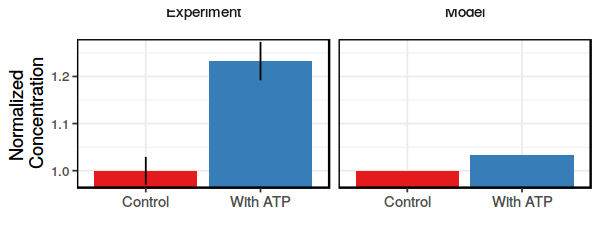

In [114]:
options(repr.plot.width = 5, repr.plot.height = 2)
comparison <- ggplot(data = center.tot.df , 
                     aes(x=Experiment, y=normalized, fill = Experiment)) + 
    geom_bar(stat = 'identity',position = 'dodge') +
    xlab("") +
    ylab("Normalized \nConcentration") +
    theme_bw() +
    coord_cartesian(ylim = c(0.978, 1.265))  +
    facet_grid(. ~Experiment.Type,
               labeller = labeller(Experiment.Type =c(exp = 'Experiment',theo = 'Model'))) +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust =20),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line(),
         legend.position = "none")  +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
scale_fill_brewer(palette = "Set1") +
scale_x_discrete(labels=c('Control','With ATP'))

print(comparison)

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

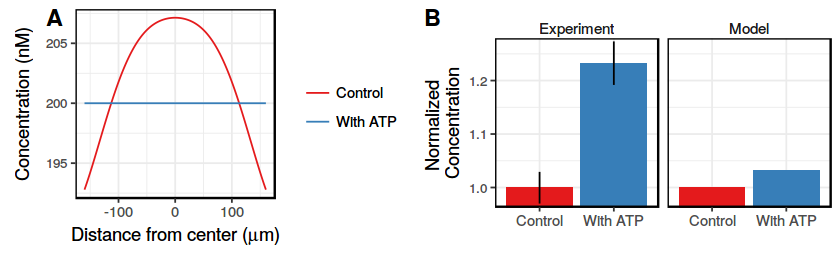

In [115]:
options(repr.plot.width = 7, repr.plot.height = 2.2)

plot_grid(model, comparison, labels = c("   A","B"),ncol = 2, rel_widths = c (1.45,1.5))

In [116]:
ggsave('../img/theoryfigv6.png',width =7, height = 2.2, dpi = 300)